In [1]:
import os
import glob
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from scripts.sample_db import SampleDB

from scripts.utils.traces_utils import extract_fluorescence_data, load_hdf5_data

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)


In [2]:

# Loading experiment
sample_id = '20210907_RM0012_5dpf_fP3_f1'  
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Making shortcuts of sample parameters/information
sample = exp.sample
trials_path = exp.paths.trials_path
n_planes = exp.params_lm.n_planes
n_trials = exp.params_lm.n_trials
doubling = 2 if exp.params_lm.doubling else 1

# Getting paths of the trial acquisitions
trial_names = os.listdir(os.path.join(trials_path, 'raw'))
processed_folder = os.path.join(trials_path, 'processed')
masks_folder = os.path.join(trials_path, "masks")

# Load the masks
masks_file = glob.glob(os.path.join(masks_folder, f'masks_{exp.sample.id}_*.tif'))[0]
masks_stack = imread(masks_file)

# Create folder for saving fluorescence data
traces_folder = os.path.join(trials_path, "traces")
os.makedirs(traces_folder, exist_ok=True)

hdf5_file_path = os.path.join(traces_folder, f'{exp.sample.id}_fluorescence_data.h5')

# Process and save data
extract_fluorescence_data(hdf5_file_path, sample_id, trial_names, processed_folder, masks_stack, n_planes, doubling)

# Load data
data = load_hdf5_data(hdf5_file_path, sample_id)
print(data.keys())

20210907_RM0012_5dpf_fP3_f1
Processing trial 1/24, shape: (8, 375, 256, 512)
Processing trial 2/24, shape: (8, 375, 256, 512)
Processing trial 3/24, shape: (8, 375, 256, 512)
Processing trial 4/24, shape: (8, 375, 256, 512)
Processing trial 5/24, shape: (8, 375, 256, 512)
Processing trial 6/24, shape: (8, 375, 256, 512)
Processing trial 7/24, shape: (8, 375, 256, 512)
Processing trial 8/24, shape: (8, 375, 256, 512)
Processing trial 9/24, shape: (8, 375, 256, 512)
Processing trial 10/24, shape: (8, 375, 256, 512)
Processing trial 11/24, shape: (8, 375, 256, 512)
Processing trial 12/24, shape: (8, 375, 256, 512)
Processing trial 13/24, shape: (8, 375, 256, 512)
Processing trial 14/24, shape: (8, 375, 256, 512)
Processing trial 15/24, shape: (8, 375, 256, 512)
Processing trial 16/24, shape: (8, 375, 256, 512)
Processing trial 17/24, shape: (8, 375, 256, 512)
Processing trial 18/24, shape: (8, 375, 256, 512)
Processing trial 19/24, shape: (8, 375, 256, 512)
Processing trial 20/24, shape: 

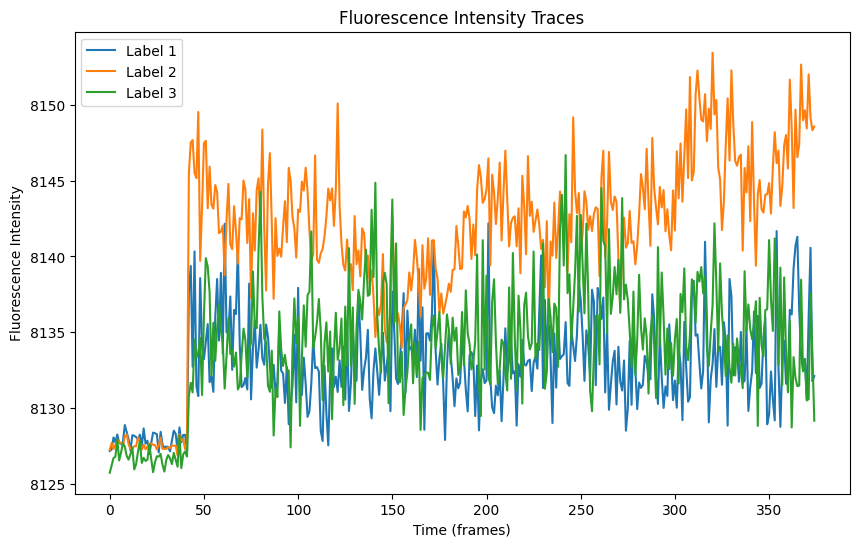

In [3]:
# Plot the first three traces
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(data['raw_traces'][i], label=f'Label {data["lm_plane_labels"][i]}')

plt.title('Fluorescence Intensity Traces')
plt.xlabel('Time (frames)')
plt.ylabel('Fluorescence Intensity')
plt.legend()
plt.show()

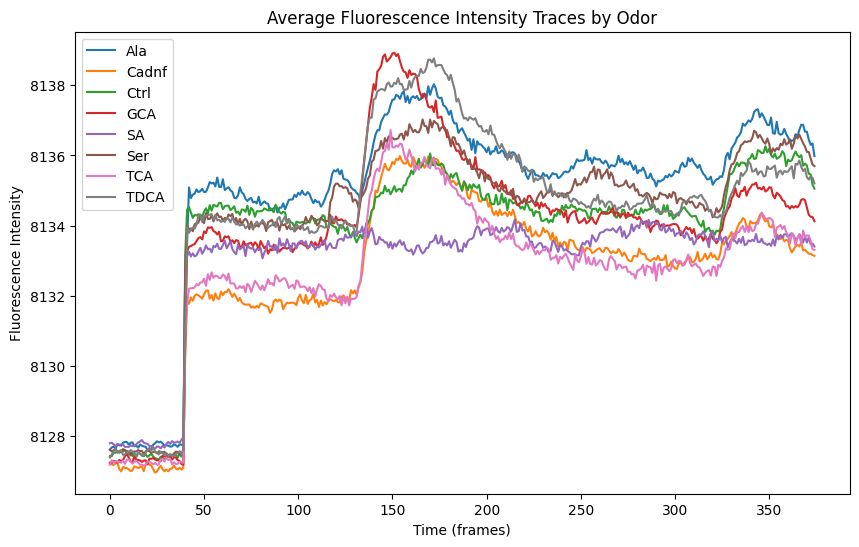

In [4]:


# Plot average traces for each odor
odors_name = np.unique(data['odor'])
plt.figure(figsize=(10, 6))
for odor in odors_name:
    plt.plot(data['raw_traces'][data['odor'] == odor].mean(axis=0), label=odor.decode('utf-8'))
plt.legend()
plt.title('Average Fluorescence Intensity Traces by Odor')
plt.xlabel('Time (frames)')
plt.ylabel('Fluorescence Intensity')
plt.show()


